This script calculates specific trends and visualizations for retail stores in the dataset available in the data folder. It is assumed that this script entails a preliminary analysis of the dataset and further deeper models can be made at each step of the way which are highlighted below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This portion of code contains any functions that are used throughout the code and any global variables the script will use. In production, this script can be its own parameters file that can be launched with the code

In [32]:
#Functions and global variables


## This function takes in a table and calculates the overall margins of those stores and then calculates the yearly mean, median margin of each store. 
## These metrics are calculated in two different ways: First, the average/median margin is calculated for one store across the year and then the average/median of these numbers are calculated
## Second, the yearly totals for every store is summed and then a margin is calculated. The mean/median of this number across all stores is then calculated. 
## Weighted average was considered however, since the nature of the investigation is to look at all stores individually and since margin of all stores are on the same scale, I did not calculate it. 
def calculate_margins(profit_table):
    profit_table['monthly_profit']=profit_table['Gross revenue']-(profit_table['Fixed cost']+profit_table['Variable cost']+profit_table['Rental cost'])
    profit_table['profit_per_product']=profit_table['monthly_profit']/profit_table['Number of products']
    profit_table['revenue_per_product']=profit_table['Gross revenue']/profit_table['Number of products']


    profit_table['monthly_net_profit_margin']=(profit_table['monthly_profit']/profit_table['Gross revenue'])*100

    profit_margin_by_location=profit_table[['Location number','Gross revenue','Fixed cost','Variable cost','monthly_profit','monthly_net_profit_margin']].groupby('Location number').agg(
        {'Gross revenue':'sum','Fixed cost':'sum','Variable cost':'sum','monthly_profit':'sum','monthly_net_profit_margin':['mean','median']}).reset_index()
    profit_margin_by_location[('yearly_profit_margin','')]=(profit_margin_by_location[('monthly_profit','sum')]/profit_margin_by_location[('Gross revenue','sum')])*100

    profit_table_all=profit_margin_by_location[[('monthly_net_profit_margin','mean'),('monthly_net_profit_margin','median'),('yearly_profit_margin','')]].agg(['mean','median','std'])


    print (profit_table_all)
    
    plot=profit_margin_by_location.hist(column=('monthly_net_profit_margin','mean'),bins=20)
    plot=profit_margin_by_location.hist(column=('monthly_net_profit_margin','median'),bins=20)
    plot=profit_margin_by_location.hist(column=('yearly_profit_margin',''),bins=20)
    
    return profit_margin_by_location,profit_table


## This function decomposes the margins in different ways. 
## First it calculates the correlation between all the stores yearly averages, 
## Then it groups by the metrics by month instead of location to determine time trends, 
## Then it calculates the correlation between these metrics across each month
def identify_drivers(rent_adj_by_location,rent_adj_all,chart_title):
    ## Looking at Location Specific Info 
    margin_correlations=rent_adj_by_location.corr(method='pearson')
    margin_correlations=margin_correlations[('monthly_net_profit_margin','mean')]
    
    print ('Correlation between each locations Profit Margin and the metric below')
    print (margin_correlations)
    print ('________________________________________________')
    
    ## Looking at Time Specific Info
    rent_adj_by_month=rent_adj_all[['Month','Gross revenue','Fixed cost','Variable cost','monthly_net_profit_margin']].groupby('Month').mean().reset_index()
    
    year_plot=rent_adj_by_month[['Month','Gross revenue','Fixed cost','Variable cost']].plot(kind='line',x='Month',title=chart_title,figsize=(10,5))
    year_plot_margin=year_plot.twinx()
    rent_adj_by_month[['Month','monthly_net_profit_margin']].plot(kind='line',x='Month',ax=year_plot_margin,color='k')
    year_plot.set_ylabel('$  Amount   in $10MM')
    year_plot_margin.set_ylabel('Profit Margin')
    year_plot.set_xlabel('Month')
    year_plot.legend().set_visible(False)
    year_plot_margin.legend().set_visible(False)
    ## Months 1-8
    subset_of_year=rent_adj_by_month[(rent_adj_by_month['Month']<=5) & (rent_adj_by_month['Month']>=1)]
    time_correl=subset_of_year.corr(method='pearson')
    time_correl=time_correl['monthly_net_profit_margin']
    
    print ('Correlation between the average Profit Margin across the subset of stores and the metric below')
    print (time_correl)
    print ('________________________________________________')    
    
    plt.show()


In [33]:
#Load Data and file audit information

raw_data=pd.read_csv('data/pmp_takehome_2019.csv')

print (raw_data.dtypes)
print (raw_data.shape)

Location number         int64
Month                   int64
State                  object
Gross revenue         float64
Fixed cost            float64
Variable cost         float64
Rental cost             int64
Number of products      int64
Owned                    bool
dtype: object
(3996, 9)


Q1. The mean profit margin of all stores is 24.33 and the median profit margin of all stores is 25.8  The margins overall are not normally distributed but has a slight left skew. This is indicated in the charts below and by the fact that the median is greater then the mean. 

The below code uses the definition above to calcualte the mean, median mode in the two ways as noted in the comments and then outputs certain graphs that show the distribution of the margins across the three different margin calculations

       monthly_net_profit_margin            yearly_profit_margin
                            mean     median                     
mean                   24.332206  24.712056            24.863229
median                 25.579551  25.801698            26.184928
std                     6.527927   6.217679             6.247394


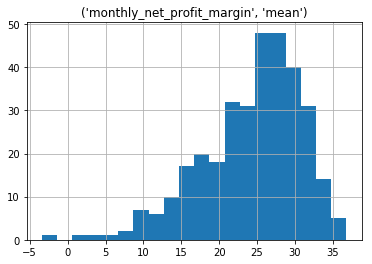

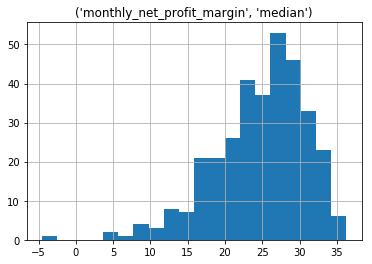

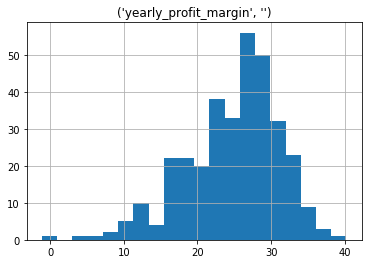

In [35]:
#### Profit Calculation

profit_table=raw_data.copy()

profit_margin_by_location,raw_profit_table=calculate_margins(profit_table)

# print (profit_margin_by_location)

Q2. The proxy for rent was simply used by calculating the average ratio between the Fixed costs and rental costs between stores that were not owned and then using that ratio to calculate a proxy rent for the rented stores. I initially thought of making a regression model, but as the charts below show (and a correlation of .6 between the revenue, costs and the rental costs) I felt a regression wouldnt be a great model as there was no distinct relation between any metric and rent. There is an opportunity for further analysis here by gathering additional data about the properties and then using a collaborative filtering model to fill in the missing rental costs 

C:\Users\Amit\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


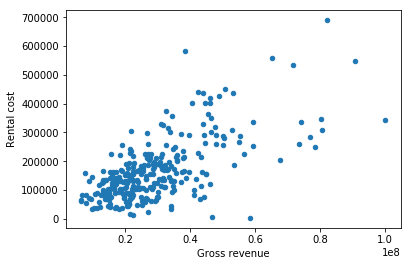

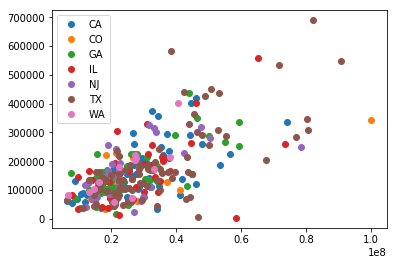

Location number       1.525867e-02
Month                 5.356378e-19
Gross revenue         6.202995e-01
Fixed cost            6.587458e-01
Variable cost         6.199505e-01
Rental cost           1.000000e+00
Number of products   -3.213613e-02
Owned                          NaN
total_costs           6.380784e-01
Name: Rental cost, dtype: float64
65.26388740973228


In [37]:
#### Finding proxy for rent 

rent_adjusted_table=raw_data.copy()

owned_properties=rent_adjusted_table[rent_adjusted_table['Owned']==False]
owned_properties['total_costs']=owned_properties['Fixed cost']+owned_properties['Variable cost']

owned_properties_average=owned_properties.groupby(['Location number','State']).mean().reset_index()
correlations=owned_properties.corr(method='pearson')
correlations=correlations['Rental cost']

rent_scatter=owned_properties_average.plot.scatter(x='Gross revenue',y='Rental cost')
groups=owned_properties_average.groupby('State')
fig,ax=plt.subplots()
for name,group in groups:
    ax.plot(group['Gross revenue'],group['Rental cost'],marker='o',linestyle='',label=name)
ax.legend()
plt.show()

print (correlations)

#### Calculating rent ratio 

rent_cost_ratio=(owned_properties_average['Fixed cost']/owned_properties['Rental cost']).mean()
print (rent_cost_ratio)

def get_rent(row,rent_cost_ratio):
    if (row['Owned']==False):
        return row['Rental cost']
    else:
        return (row['Gross revenue']/rent_cost_ratio)

rent_adjusted_table['Rental cost']=rent_adjusted_table.apply(lambda row:get_rent(row,rent_cost_ratio) ,axis=1)


After calculating the imputed rent costs, the adjusted data is sent back into the definition mentioned above and the same average and median margins are calculated. 

The rent adjusted mean profit margin is 24.17 and the median is 25.65. There isnt a huge difference in the numbers as stores that are owned only represent 14% of the total revenue, but margins did fall. 

       monthly_net_profit_margin            yearly_profit_margin
                            mean     median                     
mean                   24.166559  24.546409            24.697582
median                 25.385153  25.647052            25.876317
std                     6.443569   6.130809             6.165162


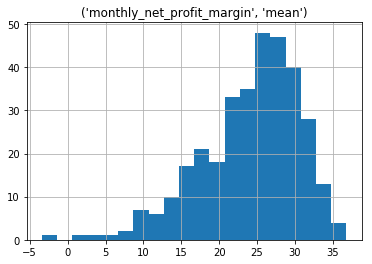

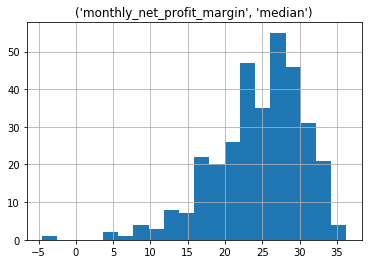

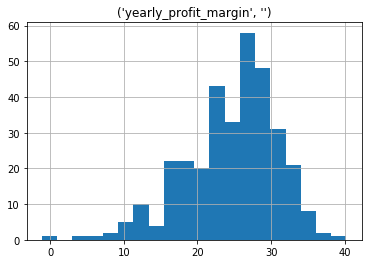

In [38]:
#### Rent Adjusted Margins

# print (rent_adjusted_table)

rent_adj_by_location,rent_adj_profit_table=calculate_margins(rent_adjusted_table)

Q3. The investigation into determining the drivers is done in a few steps: 
    1. First, the average trends are determined across all stores. The first trend is seeing the changes in time. 
        Meaning, the values are grouped by Month instead of location so that I can see a time series instead.
        By doing this, I was able to see a cyclical pattern in costs and revenue and this can tell me what the norm is. 
        The second trend is to then calculate correlations between the average margins of each store with Revenue, and costs as well as 
        the average margins in a given month with the Revenue and costs of that month. 
    2. Next, I create a subset of data. The first subset are the top quartile of stores with the highest profit margin. The second are the lowest 
        quartiles of stores with the lowest margins. I repeat the same analysis for these stores and compare the numbers 
    3. The correlations do show a relationship that the stores tend to be correlated with revenue more then costs. For underperforming stores, 
        these correlations are very high (.5-.6 range) especially for variable costs and revenue suggesting these two as good indicators 
        for profit margin. However, the correlations did not seem significantly different so I did not include them at the presentation in this time 
    4. I also quickly looked at geography. The differences in averages for each state is fairly significant
    5. Based on this there are definitely areas of further investigation, especially looking into consumer trends and geographic trends. 
        The product diversity could help be an indicator of changing revenue patterns. 


Decomposing all locations

Correlation between each locations Profit Margin and the metric below
Location number                      0.098814
Gross revenue              sum       0.486805
Fixed cost                 sum       0.313660
Variable cost              sum       0.403938
monthly_profit             sum       0.667410
monthly_net_profit_margin  mean      1.000000
                           median    0.975635
yearly_profit_margin                 0.993818
Name: (monthly_net_profit_margin, mean), dtype: float64
________________________________________________
Correlation between the average Profit Margin across the subset of stores and the metric below
Month                        0.660055
Gross revenue                0.443009
Fixed cost                  -0.015009
Variable cost                0.389170
monthly_net_profit_margin    1.000000
Name: monthly_net_profit_margin, dtype: float64
________________________________________________


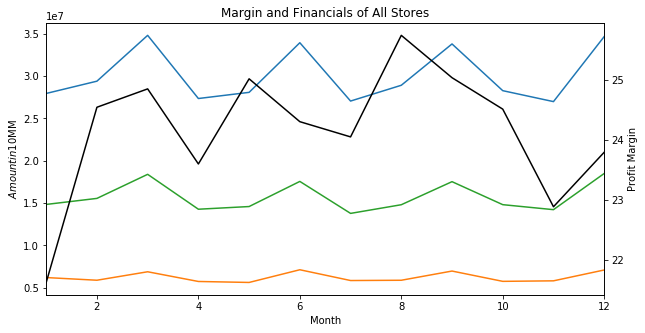

Decomposing outperforming locations

Correlation between each locations Profit Margin and the metric below
Location number                     -0.080985
Gross revenue              sum       0.147854
Fixed cost                 sum       0.100652
Variable cost              sum       0.073623
monthly_profit             sum       0.286405
monthly_net_profit_margin  mean      1.000000
                           median    0.839331
yearly_profit_margin                 0.974454
Name: (monthly_net_profit_margin, mean), dtype: float64
________________________________________________
Correlation between the average Profit Margin across the subset of stores and the metric below
Month                        0.846573
Gross revenue                0.260981
Fixed cost                  -0.324770
Variable cost                0.181419
monthly_net_profit_margin    1.000000
Name: monthly_net_profit_margin, dtype: float64
________________________________________________


C:\Users\Amit\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


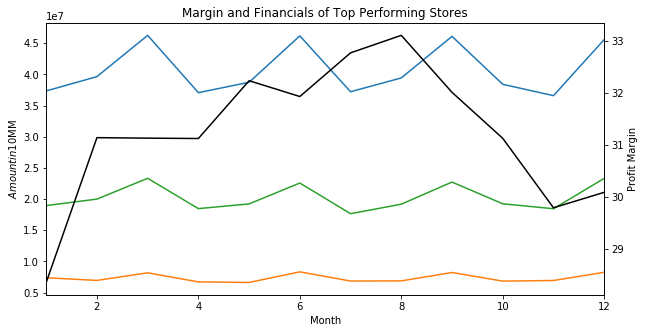

Decomposing underperforming locations

Correlation between each locations Profit Margin and the metric below
Location number                     -0.093626
Gross revenue              sum       0.259574
Fixed cost                 sum       0.092315
Variable cost              sum       0.196616
monthly_profit             sum       0.586368
monthly_net_profit_margin  mean      1.000000
                           median    0.894418
yearly_profit_margin                 0.964749
Name: (monthly_net_profit_margin, mean), dtype: float64
________________________________________________
Correlation between the average Profit Margin across the subset of stores and the metric below
Month                        0.310277
Gross revenue                0.620288
Fixed cost                   0.282747
Variable cost                0.590644
monthly_net_profit_margin    1.000000
Name: monthly_net_profit_margin, dtype: float64
________________________________________________


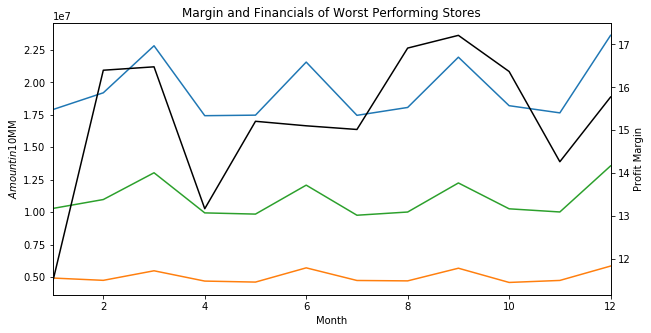

  State monthly_net_profit_margin           
                             mean        std
4    NJ                 18.862772   7.451834
2    GA                 19.872567   7.722107
6    WA                 24.079263  12.322847
3    IL                 24.436962   6.857315
1    CO                 24.803085   7.153707
0    CA                 25.151453   8.994959
5    TX                 27.301419   6.789027


In [39]:
#### Drivers of margin 


## All Stores

print ('Decomposing all locations'+'\n')
identify_drivers(rent_adj_by_location,rent_adj_profit_table,'Margin and Financials of All Stores')

## Outperforming Stores

print ('Decomposing outperforming locations'+'\n')
upper_quartile=np.percentile(rent_adj_by_location[('monthly_net_profit_margin','mean')],75)
outperforming_locations=rent_adj_by_location[rent_adj_by_location[('monthly_net_profit_margin','mean')]>=upper_quartile]
outperforming_locations_all=rent_adj_profit_table.merge(outperforming_locations[['Location number']],on='Location number',how='inner')

identify_drivers(outperforming_locations,outperforming_locations_all,'Margin and Financials of Top Performing Stores')

## Underperforming Stores

print ('Decomposing underperforming locations'+'\n')
lower_quartile=np.percentile(rent_adj_by_location[('monthly_net_profit_margin','mean')],25)
underperforming_locations=rent_adj_by_location[rent_adj_by_location[('monthly_net_profit_margin','mean')]<=lower_quartile]
underperforming_locations_all=rent_adj_profit_table.merge(underperforming_locations[['Location number']],on='Location number',how='inner')

identify_drivers(underperforming_locations,underperforming_locations_all,'Margin and Financials of Worst Performing Stores')

## Analysis by state 

profit_margin_by_state=rent_adj_profit_table[['State','monthly_net_profit_margin']].groupby('State').agg(['mean','std']).reset_index()
print (profit_margin_by_state.sort_values(by=[('monthly_net_profit_margin','mean')]))
